In [18]:
import pandas as pd
import numpy as np

In [19]:
data_wdi = pd.read_csv('./WDI_CSV/WDICSV.csv')

In [20]:
print(data_wdi.head())

                  Country Name Country Code  \
0  Africa Eastern and Southern          AFE   
1  Africa Eastern and Southern          AFE   
2  Africa Eastern and Southern          AFE   
3  Africa Eastern and Southern          AFE   
4  Africa Eastern and Southern          AFE   

                                      Indicator Name     Indicator Code  1960  \
0  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   NaN   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.RU.ZS   NaN   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.UR.ZS   NaN   
3            Access to electricity (% of population)     EG.ELC.ACCS.ZS   NaN   
4  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   NaN   

   1961  1962  1963  1964  1965  ...       2014       2015       2016  \
0   NaN   NaN   NaN   NaN   NaN  ...  17.488497  18.001597  18.558234   
1   NaN   NaN   NaN   NaN   NaN  ...   6.811504   7.096003   7.406706   
2   NaN   N

In [21]:
print(data_wdi.columns)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')


In [22]:
grp_countries = data_wdi.groupby('Country Name')
print(len(grp_countries))

266


In [23]:
indicators_filtered = ['GDP growth (annual %)',
                       'Life expectancy at birth, total (years)',
                       'Number of infant deaths',
                       'Age dependency ratio (% of working-age population)',
                       'Literacy rate, adult total (% of people ages 15 and above)',
                      #  'Income share held by fourth 20%',
                      #  'Poverty gap at $2.15 a day (2017 PPP) (%)',
                      #  'Human capital index (HCI) (scale 0-1)',
                      #  'Research and development expenditure (% of GDP)',
                       'Electric power consumption (kWh per capita)',
                       'Renewable electricity output (% of total electricity output)',
                       'Forest area (% of land area)',
                       'Arable land (% of land area)',
                       'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990)',
                       'Exports of goods and services (% of GDP)'
                       ]

countries_filtered = [
                        "United States",
                        "United Kingdom",
                        "Germany",
                        "China",
                        "India",
                        "Japan",
                        "Brazil",
                        "Indonesia",
                        "South Africa",
                        "Mexico",
                        "Niger",
                        "Chad",
                        "Haiti",
                        "Burundi"
                      ]

print(len(indicators_filtered))
print(len(countries_filtered))

11
14


In [24]:
data_wdi_filtered = data_wdi[data_wdi['Indicator Name'].isin(indicators_filtered) & data_wdi['Country Name'].isin(countries_filtered)]
print(data_wdi_filtered.shape)
print(data_wdi_filtered)
data_wdi_filtered.to_csv('data_wdi_filtered.csv', index=False)

(154, 68)
         Country Name Country Code  \
112256         Brazil          BRA   
112285         Brazil          BRA   
112329         Brazil          BRA   
112548         Brazil          BRA   
112596         Brazil          BRA   
...               ...          ...   
381953  United States          USA   
382185  United States          USA   
382192  United States          USA   
382431  United States          USA   
382695  United States          USA   

                                           Indicator Name     Indicator Code  \
112256  Age dependency ratio (% of working-age populat...        SP.POP.DPND   
112285                       Arable land (% of land area)     AG.LND.ARBL.ZS   
112329  Carbon dioxide (CO2) emissions (total) excludi...  EN.GHG.CO2.ZG.AR5   
112548        Electric power consumption (kWh per capita)  EG.USE.ELEC.KH.PC   
112596           Exports of goods and services (% of GDP)     NE.EXP.GNFS.ZS   
...                                                  

In [25]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler
import warnings

# 1. Prepare year columns (2000-2022)
year_cols = [str(y) for y in range(2000, 2023)]
data_wdi_filtered = data_wdi_filtered.copy() 
data_wdi_filtered.loc[:, year_cols] = data_wdi_filtered[year_cols].apply(pd.to_numeric, errors='coerce')

# 2. Calculate missing percentage for year columns only
missing_percent = data_wdi_filtered[year_cols].isna().mean().mean() * 100
print(f"Total missing values: {missing_percent:.2f}%")

# 3. Show pre-imputation samples with NaNs
nan_samples = data_wdi_filtered[data_wdi_filtered[year_cols].isna().any(axis=1)].sample(3, random_state=42)
print("Before Imputation - Samples with NaNs:")
print(nan_samples[['Country Name', 'Indicator Name'] + year_cols[-5:]])

# 4. Enhanced Imputation with indicator-specific scaling
def svd_imputation(df):
    final_df = df[['Country Name', 'Indicator Name']].copy()
    
    for indicator in df['Indicator Name'].unique():
        # Filter indicator data
        mask = df['Indicator Name'] == indicator
        indicator_data = df.loc[mask, year_cols]
        
        # Skip if all data is missing
        if indicator_data.isna().all().all():
            continue
        
        # Remove completely empty columns for this indicator
        valid_cols = indicator_data.columns[indicator_data.notna().any(axis=0)]
        working_data = indicator_data[valid_cols]
        
        # Skip if no valid columns exist
        if working_data.empty:
            continue
        
        # Scale to [0,1] range using MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        try:
            scaled_data = scaler.fit_transform(working_data)
        except ValueError:
            # Handle constant columns or completely missing rows
            scaled_data = working_data.fillna(0.5).values
        
        # BayesianRidge estimator for IterativeImputer
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            imputer = IterativeImputer(
                estimator=BayesianRidge(),
                max_iter=300,  # Increased iterations for better convergence
                tol=1e-4,
                random_state=42,
            )
            imputed = imputer.fit_transform(scaled_data)
        
        # Reverse scaling and clip values to original range
        final_values = scaler.inverse_transform(imputed)
        data_min = working_data.min().min()
        data_max = working_data.max().max()
        final_values = np.clip(final_values, data_min, data_max)
        
        # Reconstruct full timeline with valid columns filled in imputed values
        full_reconstructed = df.loc[mask, year_cols].copy()
        full_reconstructed[valid_cols] = final_values
        
        # Fill any remaining gaps with linear interpolation (safety net)
        full_reconstructed = full_reconstructed.interpolate(axis=1, limit_direction="both")
        
        # Store results in the final DataFrame
        final_df.loc[mask, year_cols] = full_reconstructed.values
    
    return final_df

# 5. Apply imputation to the dataset
final_data = svd_imputation(data_wdi_filtered)

# 6. Force-fill any remaining NaNs (absolute safeguard)
final_data[year_cols] = final_data[year_cols].fillna(final_data[year_cols].mean())

# 7. Show post-imputation results for the same samples
print("\nAfter Imputation - Same Samples:")
print(final_data.loc[nan_samples.index, ['Country Name', 'Indicator Name'] + year_cols[-5:]])

# 8. Final validation to ensure no NaNs remain in the dataset
remaining_nans = final_data[year_cols].isna().sum().sum()
print(f"\nRemaining NaNs: {remaining_nans}")
print("Final data shape:", final_data.shape)

assert remaining_nans == 0, "There are still NaN values"


Total missing values: 13.30%
Before Imputation - Samples with NaNs:
       Country Name                                     Indicator Name  2018  \
220624        Japan  Literacy rate, adult total (% of people ages 1...   NaN   
183224      Germany  Literacy rate, adult total (% of people ages 1...   NaN   
131367         Chad  Renewable electricity output (% of total elect...   NaN   

        2019  2020  2021  2022  
220624   NaN   NaN   NaN   NaN  
183224   NaN   NaN   NaN   NaN  
131367   NaN   NaN   NaN   NaN  

After Imputation - Same Samples:
       Country Name                                     Indicator Name  \
220624        Japan  Literacy rate, adult total (% of people ages 1...   
183224      Germany  Literacy rate, adult total (% of people ages 1...   
131367         Chad  Renewable electricity output (% of total elect...   

             2018       2019       2020       2021       2022  
220624  96.819626  77.372880  96.938937  90.000000  75.411809  
183224  96.819626  7

In [26]:
print(final_data)

         Country Name                                     Indicator Name  \
112256         Brazil  Age dependency ratio (% of working-age populat...   
112285         Brazil                       Arable land (% of land area)   
112329         Brazil  Carbon dioxide (CO2) emissions (total) excludi...   
112548         Brazil        Electric power consumption (kWh per capita)   
112596         Brazil           Exports of goods and services (% of GDP)   
...               ...                                                ...   
381953  United States                              GDP growth (annual %)   
382185  United States            Life expectancy at birth, total (years)   
382192  United States  Literacy rate, adult total (% of people ages 1...   
382431  United States                            Number of infant deaths   
382695  United States  Renewable electricity output (% of total elect...   

                2000          2001          2002          2003          2004  \
112256 

Correlation Matrix for Indicators:
Indicator Name                                      Age dependency ratio (% of working-age population)  \
Indicator Name                                                                                           
Age dependency ratio (% of working-age population)                                           1.000000    
Arable land (% of land area)                                                                -0.700836    
Carbon dioxide (CO2) emissions (total) excludin...                                          -0.727307    
Electric power consumption (kWh per capita)                                                  0.348519    
Exports of goods and services (% of GDP)                                                    -0.789449    
Forest area (% of land area)                                                                 0.792868    
GDP growth (annual %)                                                                        0.135811    
Life expect

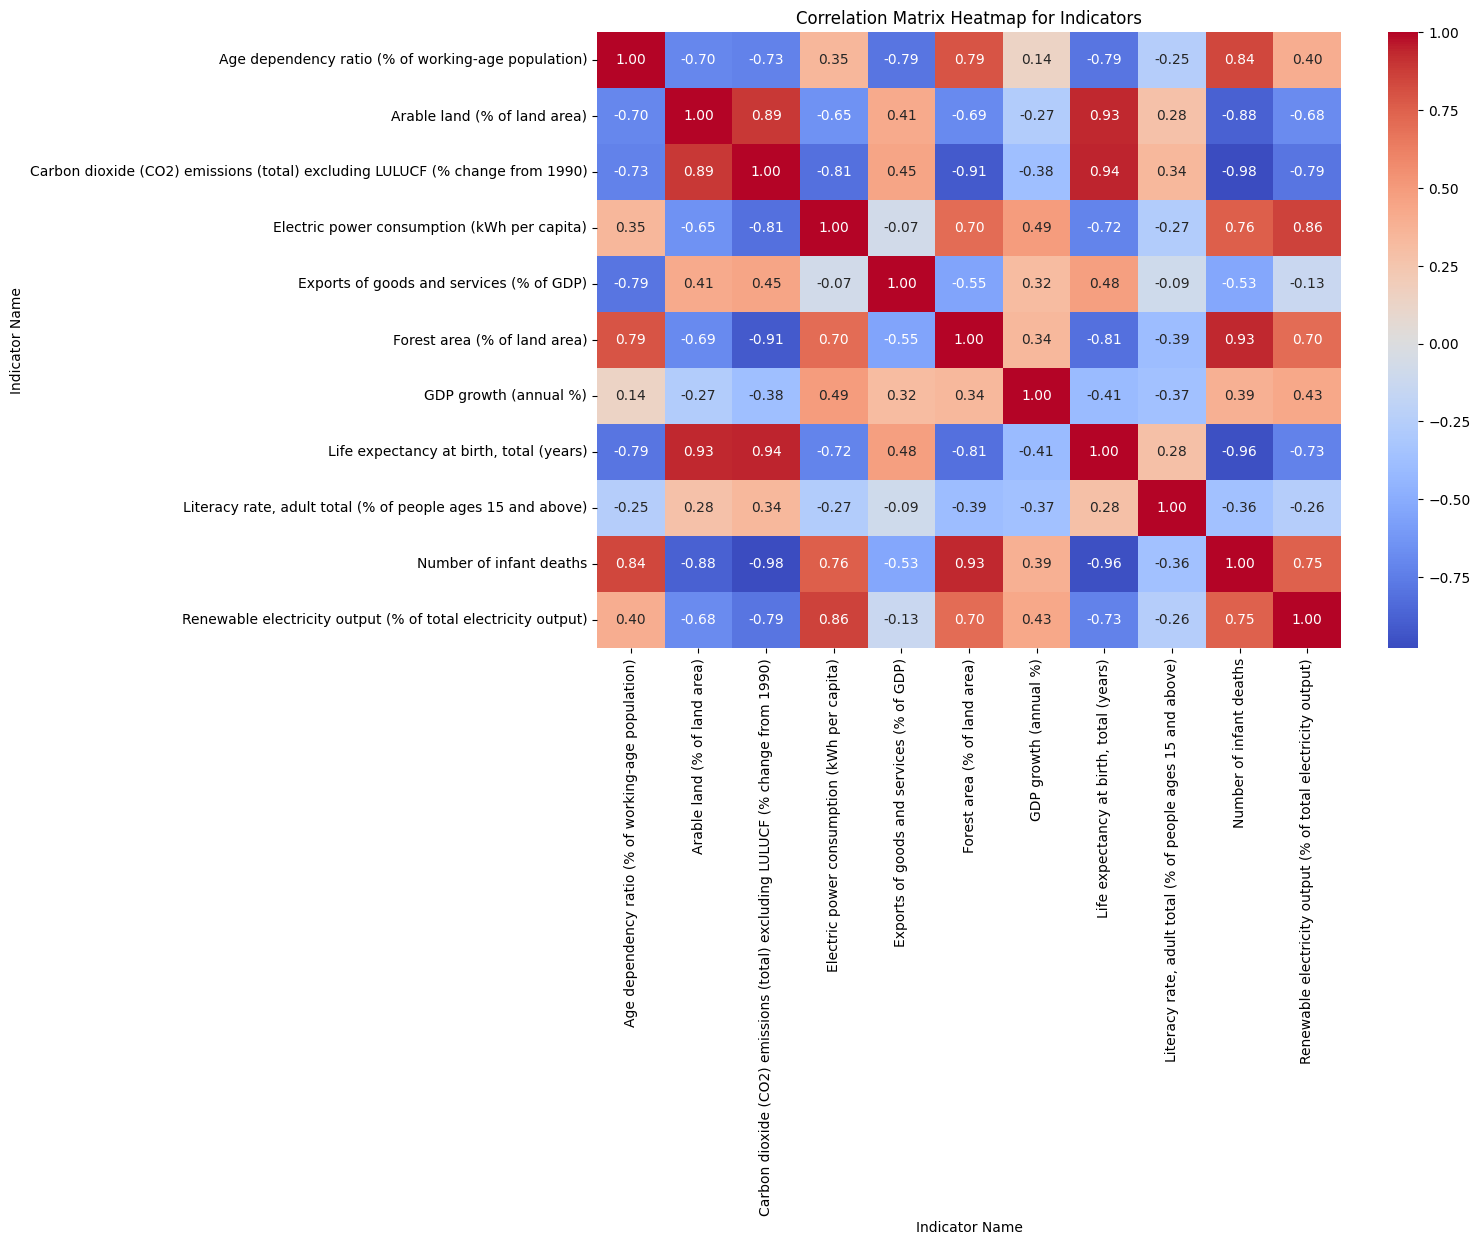

In [54]:
# 1. Aggregate data for indicators across all years
indicator_data = final_data.groupby('Indicator Name')[year_cols].mean()

# 2. Compute the correlation matrix for indicators
indicator_correlation_matrix = indicator_data.T.corr()

# 3. Print the correlation matrix
print("Correlation Matrix for Indicators:")
print(indicator_correlation_matrix)

# 4. Optional: Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(indicator_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap for Indicators")
plt.show()


Top 5 Positive Correlations:
                                          Indicator 1  \
23  Carbon dioxide (CO2) emissions (total) excludi...   
43                       Forest area (% of land area)   
15                       Arable land (% of land area)   
10                       Arable land (% of land area)   
33        Electric power consumption (kWh per capita)   

                                          Indicator 2  Correlation  
23            Life expectancy at birth, total (years)     0.943873  
43                            Number of infant deaths     0.931655  
15            Life expectancy at birth, total (years)     0.931494  
10  Carbon dioxide (CO2) emissions (total) excludi...     0.886051  
33  Renewable electricity output (% of total elect...     0.855248  

Top 5 Negative Correlations:
                                          Indicator 1  \
19  Carbon dioxide (CO2) emissions (total) excludi...   
17                       Arable land (% of land area)   
21  Carbon di

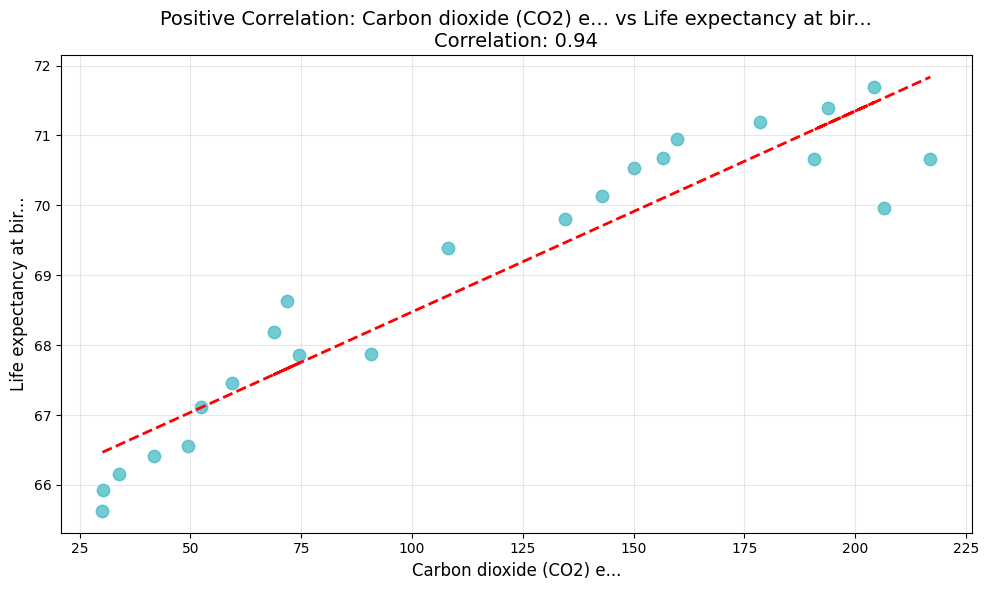

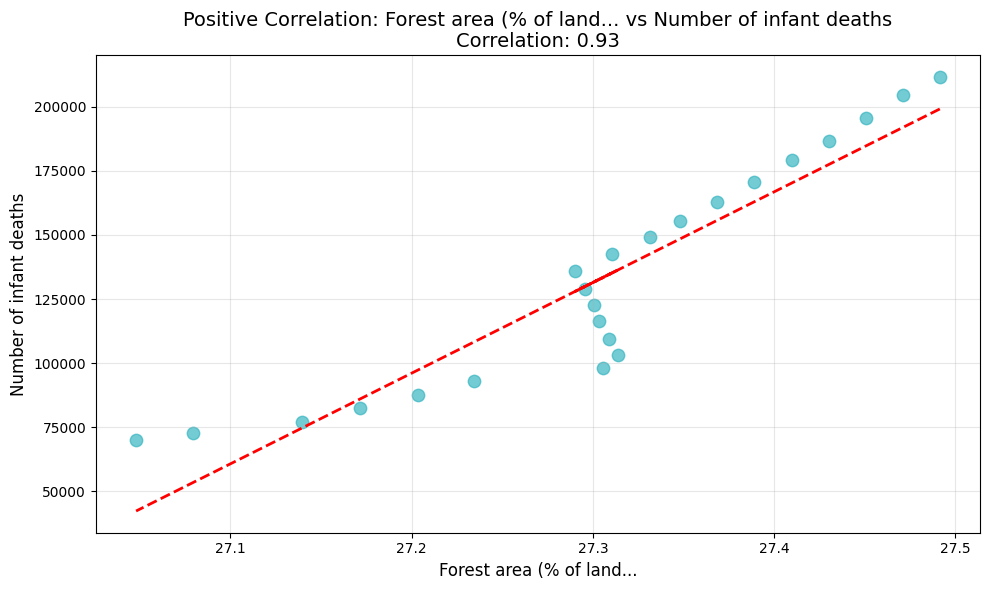

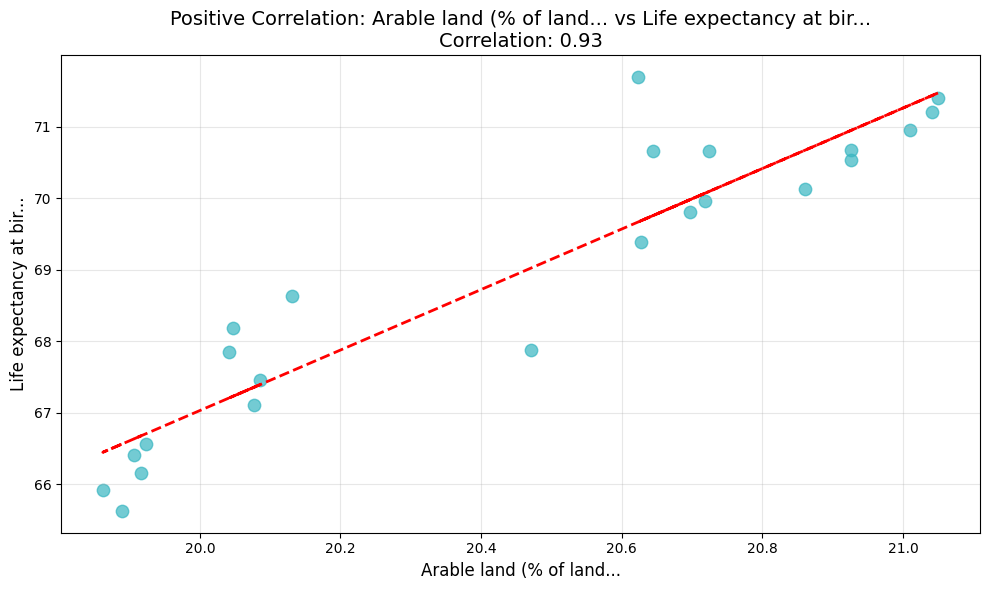

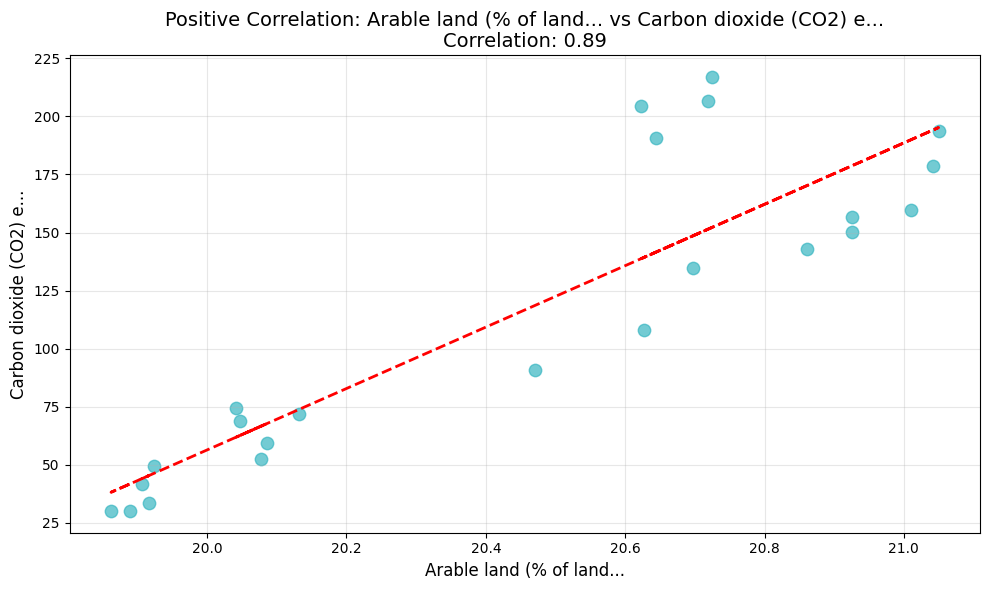

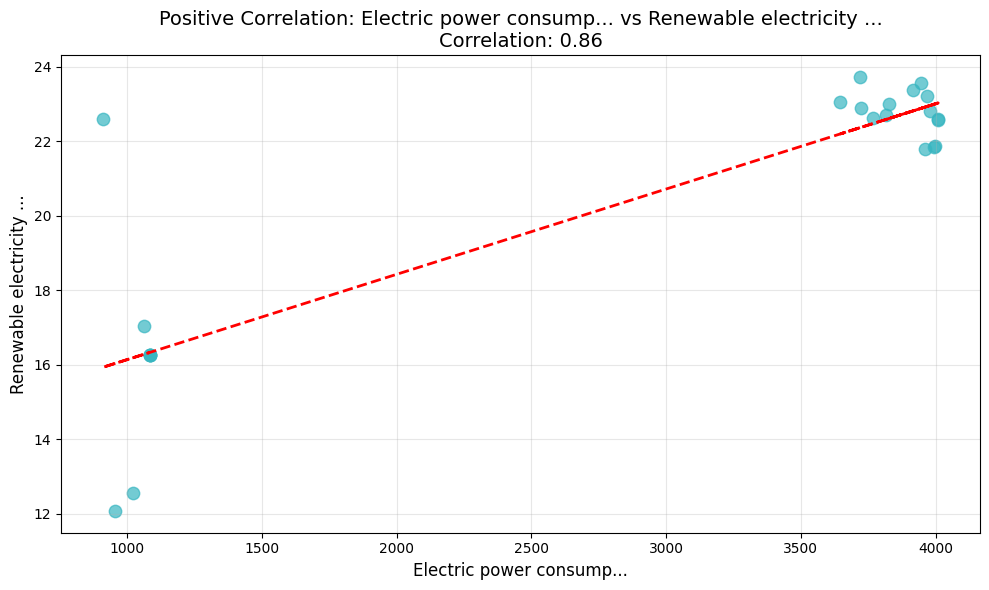

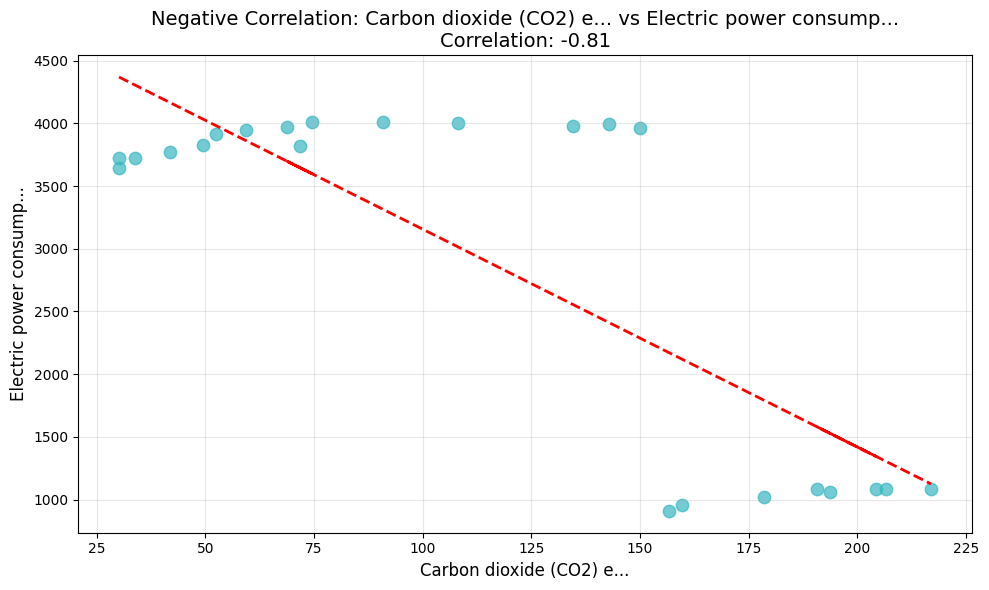

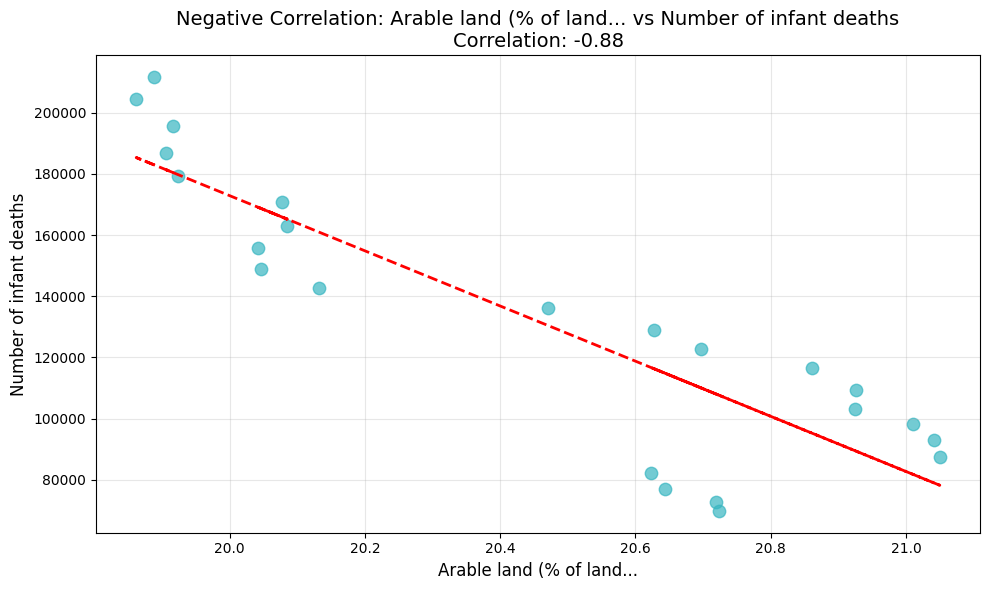

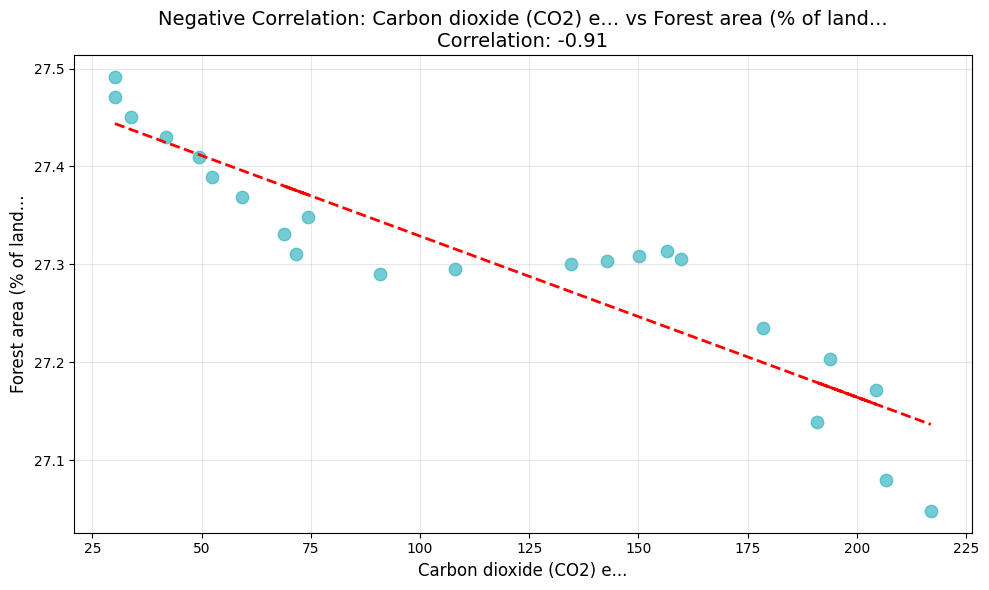

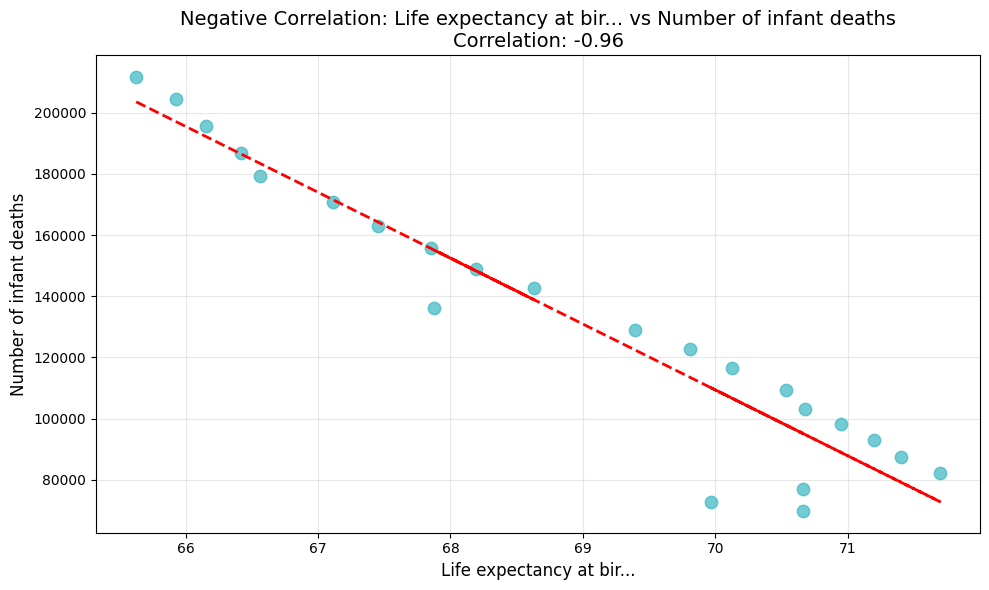

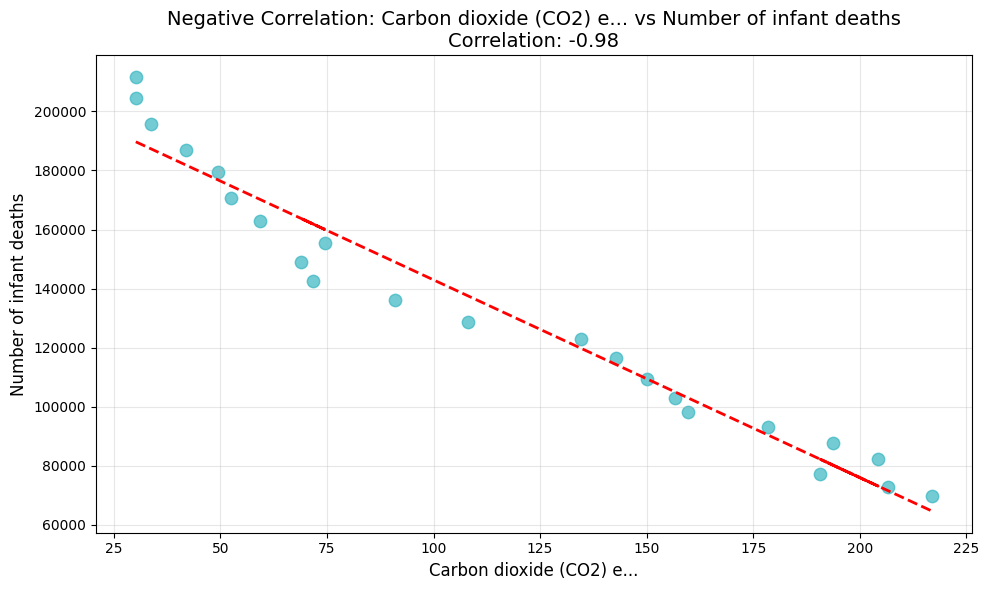

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming indicator_correlation_matrix is already calculated

# 1. Extract correlation pairs (excluding diagonal)
correlation_pairs = []
indicators = indicator_correlation_matrix.index.tolist()

for i in range(len(indicators)):
    for j in range(i+1, len(indicators)):
        ind1 = indicators[i]
        ind2 = indicators[j]
        corr_value = indicator_correlation_matrix.loc[ind1, ind2]
        correlation_pairs.append((ind1, ind2, corr_value))

# 2. Convert to DataFrame and sort
corr_df = pd.DataFrame(correlation_pairs, columns=['Indicator 1', 'Indicator 2', 'Correlation'])
corr_df = corr_df.sort_values('Correlation', ascending=False)

# 3. Get top positive and negative correlations
top_positive = corr_df.head(5)
top_negative = corr_df.tail(5)

# 4. Print the top correlations
print("Top 5 Positive Correlations:")
print(top_positive)

print("\nTop 5 Negative Correlations:")
print(top_negative)

# 5. Visualization function for indicator pairs
def plot_correlation_pair(ind1, ind2, corr_value, corr_type="Positive"):
    # Get data for the two indicators
    x = indicator_data.loc[ind1].values
    y = indicator_data.loc[ind2].values
    
    # Remove NaN values
    valid = ~(np.isnan(x) | np.isnan(y))
    x = x[valid]
    y = y[valid]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.7, s=80, color='#38b6c1')
    
    # Add trend line
    if len(x) > 1:  # Need at least 2 points for a line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), 'r--', linewidth=2)
    
    # Format labels for readability
    ind1_short = ind1 if len(ind1) < 25 else ind1[:22] + "..."
    ind2_short = ind2 if len(ind2) < 25 else ind2[:22] + "..."
    
    plt.title(f"{corr_type} Correlation: {ind1_short} vs {ind2_short}\nCorrelation: {corr_value:.2f}", fontsize=14)
    plt.xlabel(ind1_short, fontsize=12)
    plt.ylabel(ind2_short, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 6. Plot top positive correlations
for _, row in top_positive.iterrows():
    plot_correlation_pair(row['Indicator 1'], row['Indicator 2'], row['Correlation'], "Positive")

# 7. Plot top negative correlations
for _, row in top_negative.iterrows():
    plot_correlation_pair(row['Indicator 1'], row['Indicator 2'], row['Correlation'], "Negative")


In [53]:
import pandas as pd
import pandas as pd
import plotly.express as px

def plot_data(indicator_name):

    df = pd.read_csv('data_wdi_filtered.csv')

    
    id_vars = ['Country Name', 'Indicator Name']
    value_vars = [col for col in df.columns[-24:] if col not in id_vars]

    df_long = df.melt(id_vars=id_vars, value_vars=value_vars,
                    var_name='Year', value_name='Value')

    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')

    grouped = df_long.groupby('Indicator Name')

    data = grouped.get_group(indicator_name)
    
    
    fig = px.line(data,
                    x='Year',
                    y='Value',
                    color='Country Name',      
                    markers=True,
                    title=indicator_name)
        
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Value',
        legend_title='Country'
    )

    fig.show()
    del df_long,df


for indicator in indicators_filtered:
    plot_data(indicator)
    

